# Robustbench Testing
```shell
pip install git+https://github.com/RobustBench/robustbench.git
```

In [2]:
from robustbench.utils import load_model
from robustbench.model_zoo.enums import ThreatModel
import torch 
from pathlib import Path

base_model = load_model(model_name='Standard', model_dir='download/robustbench/testing/', dataset='cifar10', threat_model=ThreatModel.corruptions)
saved_path = 'saved/robustbench/testing'
Path(saved_path).mkdir(parents=True, exist_ok=True)
saved_model_path = saved_path + '/model.pt'
torch.save(base_model, saved_model_path)
base_model


WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [3]:
from robustbench.data import load_cifar10c
from robustbench.utils import clean_accuracy
import pandas as pd

records = pd.DataFrame(columns=['eval_type', 'corruption_type', 'serverity', 'accuracy'])

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

distribution_shifts = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 
    'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 
    'jpeg_compression'
]
model = torch.load(saved_model_path).to(device=dev)
model.eval()
for severity_id in range(5, 0, -1):
    for corruption in distribution_shifts:
        x_test, y_test = load_cifar10c(
            n_examples=1000, data_dir='download/robustbench/data/cifar10c', severity=severity_id, shuffle=True,
            corruptions=[corruption]
        )
        x_test, y_test = x_test.to(dev), y_test.to(dev)
        accuracy = clean_accuracy(model=model, x=x_test, y=y_test, batch_size=200)
        records.loc[len(records)] = ['origin', corruption, severity_id, accuracy]

records.head()

,eval_type,corruption_type,serverity,accuracy
0,origin,gaussian_noise,5,0.271
1,origin,shot_noise,5,0.353
2,origin,impulse_noise,5,0.281
3,origin,defocus_blur,5,0.515
4,origin,glass_blur,5,0.459


# Test-time Normalization Adaptation

In [4]:
from utils.normAdapt import NormAdapt, get_states

model = torch.load(saved_model_path)
model.eval()
model = NormAdapt(model=model).to(device=dev)

for severity_id in range(5, 0, -1):
    for corruption in distribution_shifts:
        model.reset()

        x_test, y_test = load_cifar10c(
            n_examples=1000, data_dir='download/robustbench/data/cifar10c', severity=severity_id, shuffle=True,
            corruptions=[corruption]
        )
        x_test, y_test = x_test.to(dev), y_test.to(dev)
        accuracy = clean_accuracy(model=model, x=x_test, y=y_test, batch_size=200)
        records.loc[len(records)] = ['norm', corruption, severity_id, accuracy]
records.tail()
        

,eval_type,corruption_type,serverity,accuracy
145,norm,brightness,1,0.951
146,norm,contrast,1,0.948
147,norm,elastic_transform,1,0.916
148,norm,pixelate,1,0.930
149,norm,jpeg_compression,1,0.879


# Evaluation

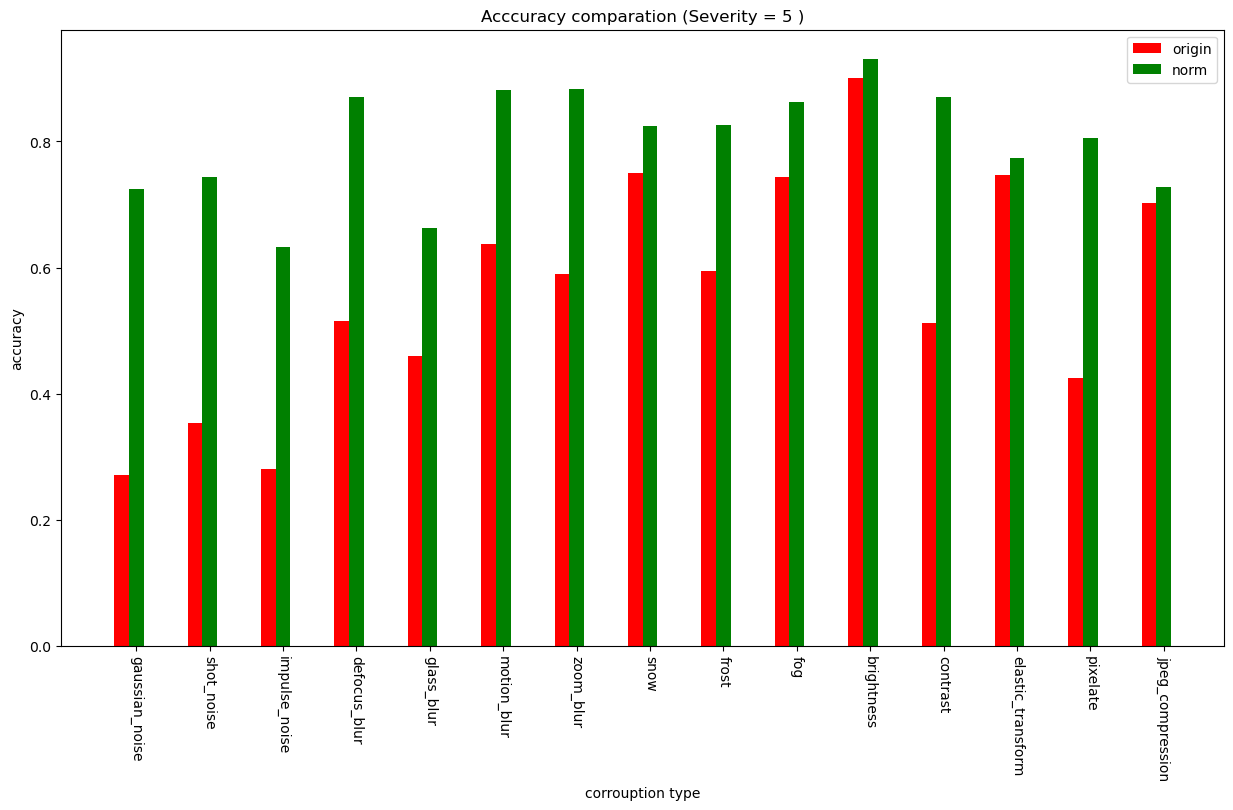

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = records['corruption_type'].unique()
ind = np.arange(len(x_labels))
width = .2
plt.figure(figsize=(15,8))
bar1 = plt.bar(x=ind, height=records[(records['eval_type'] == 'origin') & (records['serverity'] == 5)]['accuracy'].to_numpy(), width=width, color='r')
bar2 = plt.bar(x=ind+width, height=records[(records['eval_type'] == 'norm') & (records['serverity'] == 5)]['accuracy'].to_numpy(), width=width, color='g')

plt.legend((bar1, bar2), ('origin', 'norm'))
plt.xticks(ticks=ind+width, labels=x_labels, rotation=270)
plt.xlabel('corrouption type')
plt.ylabel('accuracy')
plt.title('Acccuracy comparation (Severity = 5 )')
plt.show()
